## Read the cleaned contents

In [ ]:
import os
import re
from collections import defaultdict
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from bs4 import BeautifulSoup
import gc

In [2]:
def read_txt_files(folder_path):
    """Reads all .txt files in a given folder and stores their contents in a dictionary.

    Args:
        folder_path: The path to the folder containing the .txt files.

    Returns:
        A dictionary where the keys are the filenames (without the .txt extension) and the values are the file contents.
    """

    file_contents = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath,'r') as f:
                file_contents[filename[:-4]] = f.read() # [:-4] to remove the .txt extension
    return file_contents

### Read the html content (for creating the links information)

In [3]:
html_folder_path = r"./onepiece"
html_content_dict = read_txt_files(html_folder_path)

In [4]:
# Print the first key and value in the dictionary
key = list(html_content_dict.keys())[0]
value = html_content_dict[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: A O
Value: <!DOCTYPE html>
<html class="client-nojs sse-other" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>A O | One Piece Wiki | Fandom</title>
<script>document.documentElement.className="client-js sse-other";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"5bb2d71cef47a005eab30f8314307a8f","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"A_O","wgTitle":"A O","wgCurRevisionId":2024738,"wgRevisionId":2024738,"wgArticleId":45158,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Humans","Male Characters","Pirate Captains","Whitebeard Pirates' Subordinates","Swordsmen"],"wgPageContentLanguage":"en","wgPageContentModel":"wi

### Read the clear content for the word count

In [5]:
clear_content_folder_path = r"./onepiece_cleaned"
clear_content_dict = read_txt_files(clear_content_folder_path)

In [6]:
# Print the first key and value in the dictionary
key = list(clear_content_dict.keys())[0]
value = clear_content_dict[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: A O
Value: A O
is an infamous
New World
pirate
and
captain
of the
A O Pirates
.
He and his crew were subordinates to
Whitebeard
.
Appearance
[
]
A O is a very tall man with a long, square shaped face, hollow eyes under prominent eyebrows, dark sideburns that go all the way down to his chin, and greenish long wavy hair. On his head, he wears a yellow and brown striped bandanna and over it is a tricorn captain's hat with what appears to be his
Jolly Roger
on it, a white skull wearing an animal-like hood. He also wears a dark blue, open shirt with the sleeves rolled up and a ruffled collar, and elaborate earrings made up by three little jewels each on both ears.
Personality
[
]
Not much is known about A O's personality other than that he is very loyal to
Whitebeard
since he was willing to risk his own life to save
Ace
from execution instead of fleeing through the path he had cleared with his
power
.
He was overjoyed when
Luffy
saved Ace, cheering with his fellow allies.
Relationships

### Function to extract number of references and words of each character

In [ ]:
def generate_word_count_dict(clear_content_dict):
    """
    Generate a dictionary with character names and their word count from clear text content.
    
    :param clear_content_dict: Dictionary with character names as keys and clear text as values.
    :return: Dictionary with character names as keys and word counts as values.
    """
    word_count_dict = {}
    for character, content in clear_content_dict.items():
        word_count_dict[character] = len(content.split())
    return word_count_dict

def clean_html_content(html_content):
    """
    Cleans the HTML content by removing unwanted sections and unnecessary elements.

    Args:
        html_content (str): The raw HTML content of a character's page.

    Returns:
        BeautifulSoup: Cleaned HTML content within the main content container.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Locate the main content container
    content_div = soup.find('div', class_='mw-parser-output')
    if not content_div:
        return None
    
    # Remove unwanted sections based on headers
    unwanted_sections = ["Site Navigation", "Gallery", "Trivia", "References", "Navigation"]
    for header in content_div.find_all(['h2', 'h3', 'h4']):
        if any(section in header.get_text() for section in unwanted_sections):
            # Remove header and all its sibling content until the next section
            for sibling in header.find_next_siblings():
                if sibling.name in ['h2', 'h3', 'h4']:
                    break
                sibling.extract()
            header.extract()

    return content_div

def create_relationships(html_data, word_count_data):
    """
    Creates a dictionary summarizing character relationships based on cleaned HTML content.

    Args:
        html_data (dict): A dictionary with character names as keys and raw HTML content as values.
        word_count_data (dict): A dictionary with character names as keys and word counts as values.

    Returns:
        dict: A summary dictionary with word counts, mentions, and mentioned_by relationships.
    """
    # Initialize the character summary dictionary
    unique_characters = set(html_data.keys())
    char_summary = {
        char: {"mentions": set(), "word_count": word_count_data.get(char, 0), "mentioned_by": set()}
        for char in unique_characters
    }

    for character, html_content in html_data.items():
        # Clean the HTML content for the character
        cleaned_content = clean_html_content(html_content)
        if not cleaned_content:
            continue

        # Extract valid mentions from <a> tags with titles matching unique_characters
        mentioned_chars = set()
        for link in cleaned_content.find_all('a', href=True, title=True):
            mentioned_char = link['title']
            if mentioned_char in unique_characters and mentioned_char != character:
                mentioned_chars.add(mentioned_char)

        # Update mentions for the current character
        char_summary[character]["mentions"] = mentioned_chars

        # Update mentioned_by for each mentioned character
        for mentioned_char in mentioned_chars:
            char_summary[mentioned_char]["mentioned_by"].add(character)
    
    # Convert sets back to lists for consistent output format
    for character, summary in char_summary.items():
        summary["mentions"] = sorted(summary["mentions"])
        summary["mentioned_by"] = sorted(summary["mentioned_by"])

    return dict(sorted(char_summary.items()))

def cleanup_memory(*dictionaries):
    """
    Clear dictionaries and force garbage collection to free memory.
    
    :param dictionaries: List of dictionaries to be cleared from memory.
    """
    for dictionary in dictionaries:
        if isinstance(dictionary, dict):
            dictionary.clear()
    
    # Explicitly delete the dictionaries and run garbage collection
    for dictionary in dictionaries:
        del dictionary
    gc.collect()
    print("Cleared dictionaries from memory and invoked garbage collection.")

In [9]:
# Generate word count dictionary
word_count_dict = generate_word_count_dict(clear_content_dict)
# Create character relationships
char_summary = create_relationships(html_content_dict, word_count_dict)

# Cleanup memory for dictionarie    s
cleanup_memory(clear_content_dict, html_content_dict, word_count_dict)

Cleared dictionaries from memory and invoked garbage collection.


In [10]:
# Save summary as json
import json
with open("character_summary.json", "w") as f:
    json.dump(char_summary, f, indent=4)

In [11]:
# Print the first key and value in the summary dictionary
key = list(char_summary.keys())[1]
value = char_summary[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: Koito
Value: {'mentions': ['Roronoa Zoro'], 'word_count': 112, 'mentioned_by': []}


In [ ]:
# Function 2: Analyze and plot distributions
def analyze_and_plot(char_summary: Dict[str, Dict[str, any]]):
    # Extract data
    mention_counts = [len(data["mentions"]) for data in char_summary.values()]
    in_reference_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    
    # Helper to calculate statistics
    def compute_stats(data: List[int]) -> Dict[str, float]:
        mean = np.mean(data)
        median = np.median(data)
        ci = stats.norm.interval(0.95, loc=mean, scale=np.std(data) / np.sqrt(len(data)))
        return {"mean": mean, "median": median, "ci_low": ci[0], "ci_high": ci[1]}

    # Compute statistics
    mention_stats = compute_stats(mention_counts)
    in_ref_stats = compute_stats(in_reference_counts)
    word_count_stats = compute_stats(word_counts)
    
    # Print statistics
    print("Mention Stats:", mention_stats)
    print("In-Reference Stats:", in_ref_stats)
    print("Word Count Stats:", word_count_stats)
    
    # Plot distributions
    plt.figure(figsize=(18, 6))
    
    # Mentions Plot
    plt.subplot(1, 3, 1)
    plt.hist(mention_counts, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Mentions Distribution\nMean: {mention_stats["mean"]:.2f}, Median: {mention_stats["median"]:.2f}, CI: ({mention_stats["ci_low"]:.2f}, {mention_stats["ci_high"]:.2f})')
    plt.xlabel('Number of Mentions')
    plt.ylabel('Frequency')
    
    # In-Reference Plot
    plt.subplot(1, 3, 2)
    plt.hist(in_reference_counts, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.title(f'In-References Distribution\nMean: {in_ref_stats["mean"]:.2f}, Median: {in_ref_stats["median"]:.2f}, CI: ({in_ref_stats["ci_low"]:.2f}, {in_ref_stats["ci_high"]:.2f})')
    plt.xlabel('Number of In-References')
    plt.ylabel('Frequency')
    
    # Word Count Plot
    plt.subplot(1, 3, 3)
    plt.hist(word_counts, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    plt.title(f'Word Count Distribution\nMean: {word_count_stats["mean"]:.2f}, Median: {word_count_stats["median"]:.2f}, CI: ({word_count_stats["ci_low"]:.2f}, {word_count_stats["ci_high"]:.2f})')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

Mention Stats: {'mean': 11.355989232839839, 'median': 8.0, 'ci_low': 10.77155068538157, 'ci_high': 11.940427780298108}
In-Reference Stats: {'mean': 11.355989232839839, 'median': 3.0, 'ci_low': 9.641382605604305, 'ci_high': 13.070595860075374}
Word Count Stats: {'mean': 1332.7294751009422, 'median': 540.0, 'ci_low': 1230.176966697039, 'ci_high': 1435.2819835048454}


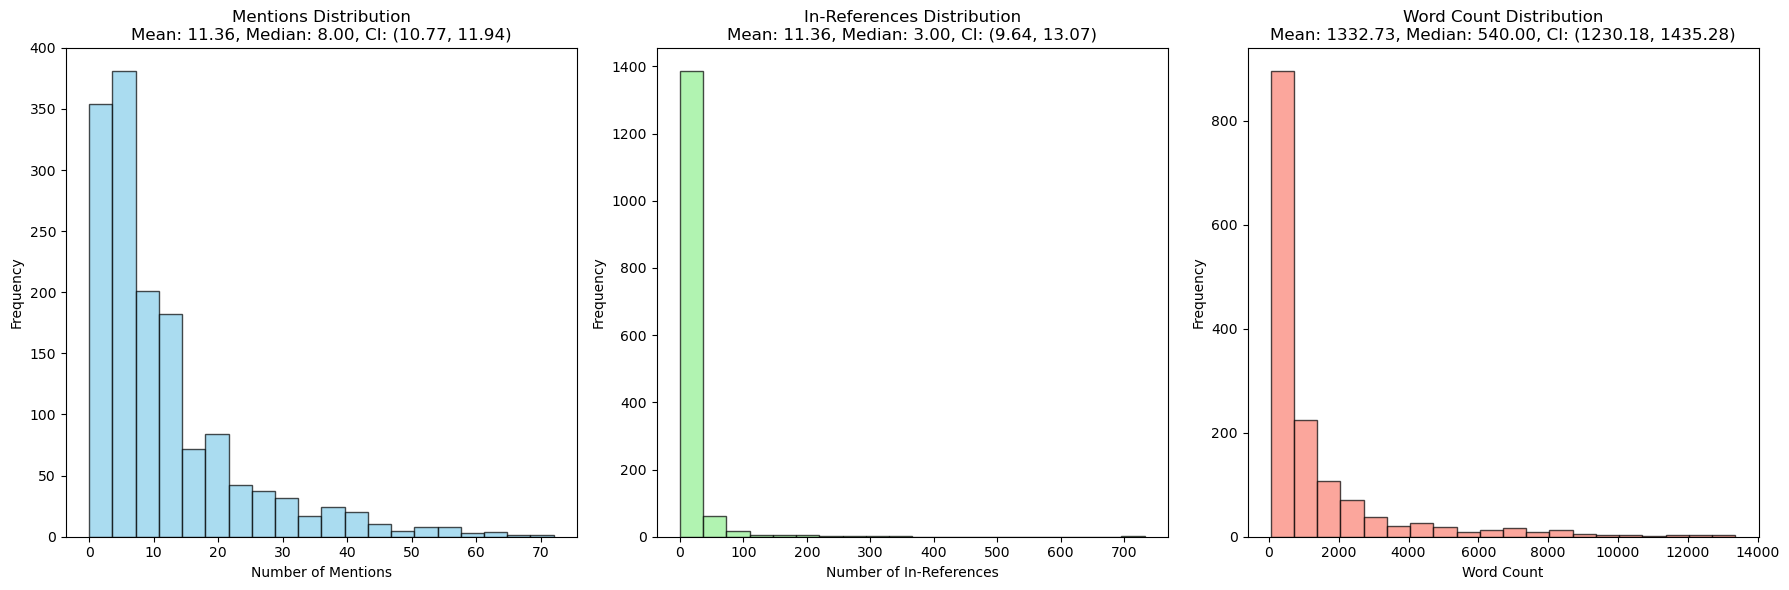

In [13]:
analyze_and_plot(char_summary)

To prune characters effectively using the three metrics (**in-mentions**, **word count**, and **out-mentions**), we can adopt ranking strategies that prioritize **in-mentions** and **word count** while still accounting for **out-mentions**. Below are some approaches to solve this:

---

### **Option 1: Weighted Scoring**
Assign weights to each metric based on its importance. Compute a total score for each character, and filter characters based on their scores:
1. **Define Weights**:
   - Assign higher weights to **in-mentions** and **word count** compared to **out-mentions**.
   - Example: `in-mentions = 0.4`, `word count = 0.4`, `out-mentions = 0.2`.
2. **Score Formula**:
   ```python
   score = 0.4 * normalized_in_mentions + 0.4 * normalized_word_count + 0.2 * normalized_out_mentions
   ```
   Normalize the values to a range of `[0, 1]` using min-max scaling:
   ```python
   normalized_value = (value - min_value) / (max_value - min_value)
   ```
3. **Sort and Filter**:
   - Rank characters by their scores and prune based on a threshold or keep the top N characters.

---

### **Option 2: Multi-Metric Ranking**
Rank characters separately by each metric and combine their rankings to create a composite rank:
1. **Rank by Each Metric**:
   - Create three sorted lists: 
     - By **in-mentions** (descending).
     - By **word count** (descending).
     - By **out-mentions** (descending).
   - Assign a rank to each character for each metric.
2. **Weighted Rank Sum**:
   - Compute a combined rank for each character using weights (e.g., `in-mentions_rank * 0.4 + word_count_rank * 0.4 + out_mentions_rank * 0.2`).
3. **Filter**:
   - Keep characters with the lowest combined ranks.

---

### **Option 3: Pareto Optimal Filtering**
Use a **Pareto frontier approach** to retain characters that are optimal with respect to the three metrics:
1. **Pareto Principle**:
   - A character is considered "better" if no other character outperforms it in all three metrics.
2. **Filter with Thresholds**:
   - Define a threshold for each metric (e.g., `in-mentions > 3`, `word count > 50`) and retain only characters satisfying these thresholds.

---

### **Option 4: Custom Rule-Based Filtering**
Define a set of rules to prune characters explicitly based on your priorities:
1. **Rules**:
   - Retain characters with **in-mentions > X** or **word count > Y** regardless of their out-mentions.
   - Optionally, remove characters with **out-mentions < Z**.
2. **Implementation**:
   - Iterate through the dictionary, applying the rules and removing characters that fail.

---

### **How to Choose?**
- **Weighted Scoring**: Flexible and provides a continuous score. Good if you want to rank characters and pick the top ones.
- **Multi-Metric Ranking**: Provides transparency in how rankings are combined. Better if you want to understand relative importance.
- **Pareto Filtering**: Useful for retaining the "best" characters without predefined thresholds. May require manual inspection of results.
- **Rule-Based Filtering**: Simple and fast if you know specific thresholds for pruning.

---

### Example Code: Weighted Scoring

```python
def prune_characters(char_summary, weights={"in": 0.4, "words": 0.4, "out": 0.2}, keep_top=10):
    # Extract metrics
    in_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    out_counts = [len(data["mentions"]) for data in char_summary.values()]
    
    # Normalize metrics
    def normalize(data):
        min_val, max_val = min(data), max(data)
        return [(x - min_val) / (max_val - min_val) if max_val > min_val else 0 for x in data]
    
    norm_in_counts = normalize(in_counts)
    norm_word_counts = normalize(word_counts)
    norm_out_counts = normalize(out_counts)
    
    # Compute weighted scores
    scores = {}
    for idx, char in enumerate(char_summary):
        scores[char] = (
            weights["in"] * norm_in_counts[idx] +
            weights["words"] * norm_word_counts[idx] +
            weights["out"] * norm_out_counts[idx]
        )
    
    # Sort characters by scores
    sorted_characters = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    # Keep top N characters
    pruned_summary = {char: char_summary[char] for char, score in sorted_characters[:keep_top]}
    return pruned_summary
```

### Example Code: Multi-Metric Ranking

```python
def prune_characters_by_rank(char_summary, weights={"in": 0.4, "words": 0.4, "out": 0.2}, keep_top=10):
    # Extract metrics
    in_counts = {char: len(data["mentioned_by"]) for char, data in char_summary.items()}
    word_counts = {char: data["word_count"] for char, data in char_summary.items()}
    out_counts = {char: len(data["mentions"]) for char, data in char_summary.items()}
    
    # Rank characters by each metric
    def rank(data):
        return {k: rank for rank, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[1], reverse=True), 1)}
    
    in_ranks = rank(in_counts)
    word_ranks = rank(word_counts)
    out_ranks = rank(out_counts)
    
    # Compute weighted rank sum
    scores = {
        char: (
            weights["in"] * in_ranks[char] +
            weights["words"] * word_ranks[char] +
            weights["out"] * out_ranks[char]
        )
        for char in char_summary
    }
    
    # Sort characters by scores
    sorted_characters = sorted(scores.items(), key=lambda x: x[1])
    
    # Keep top N characters
    pruned_summary = {char: char_summary[char] for char, score in sorted_characters[:keep_top]}
    return pruned_summary

def pareto_filter(char_summary):
    # Extract metrics
    metrics = [
        (char, len(data["mentioned_by"]), data["word_count"], len(data["mentions"]))
        for char, data in char_summary.items()
    ]
    
    # Pareto frontier computation
    pareto_frontier = []
    for char, in_count, word_count, out_count in metrics:
        if not any(
            other_in > in_count and other_words > word_count and other_out > out_count
            for _, other_in, other_words, other_out in metrics
        ):
            pareto_frontier.append(char)
    
    # Return filtered dictionary
    return {char: char_summary[char] for char in pareto_frontier}


def percentile_filter(char_summary, percentile=90):
    # Extract metrics
    in_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    out_counts = [len(data["mentions"]) for data in char_summary.values()]
    
    # Compute percentile thresholds
    in_threshold = np.percentile(in_counts, percentile)
    word_threshold = np.percentile(word_counts, percentile)
    out_threshold = np.percentile(out_counts, percentile)
    
    # Filter characters
    filtered_summary = {
        char: data for char, data in char_summary.items()
        if len(data["mentioned_by"]) >= in_threshold
        or data["word_count"] >= word_threshold
        or len(data["mentions"]) >= out_threshold
    }
    
    return filtered_summary
```
---

### Key Notes
1. **Pareto Filtering**:
   - Retains characters that cannot be strictly outperformed on all metrics by others.
   - Tends to keep a diverse set of "strong" characters.

2. **Percentile-Based Filtering**:
   - Removes characters that fall below the 90th percentile in **all** metrics.
   - Adjustable by changing the `percentile` parameter (e.g., to 85% or 95%).


**We can discuss the other strategies but for now I would keep the rank one**

In [15]:
import json
# Read the character summary from the JSON file
with open("character_summary.json", "r") as f:
    summary = json.load(f)

In [16]:
def sort_summary_by_metric(char_summary, metric):
    """
    Sorts the character summary dictionary by the specified metric.

    Args:
        char_summary (dict): Dictionary containing character data.
        metric (str): The metric to sort by ('mentioned_by', 'word_count', 'mentions').

    Returns:
        dict: Sorted dictionary based on the specified metric.
        list: Sorted list of tuples (character, metric value) for debugging or inspection.
    """
    # Sort the dictionary by the specified metric
    sorted_summary = dict(sorted(char_summary.items(), key=lambda x: len(x[1][metric]) if metric in ['mentioned_by', 'mentions'] else x[1][metric], reverse=True))
    
    # Extract values for debugging/inspection
    metric_values = [(char, len(data[metric]) if metric in ['mentioned_by', 'mentions'] else data[metric]) for char, data in sorted_summary.items()]
    
    return sorted_summary, metric_values


In [17]:
sorted_by_in, in_values = sort_summary_by_metric(summary, 'mentioned_by')
print("Sorted by In-Mentions:")
for char, value in in_values:
    print(f"{char}: {value}")

Sorted by In-Mentions:
Monkey D. Luffy: 732
Sanji: 360
Roronoa Zoro: 318
Nami: 300
Usopp: 274
Charlotte Linlin: 226
Kaidou: 223
Nico Robin: 221
Tony Tony Chopper: 217
Portgas D. Ace: 214
Vegapunk: 209
Jinbe: 197
Franky: 182
Donquixote Doflamingo: 181
Edward Newgate: 170
Trafalgar D. Water Law: 166
Brook: 141
Gol D. Roger: 134
Shanks: 132
Crocodile: 117
Kin'emon: 112
Kurozumi Orochi: 111
Marshall D. Teach: 108
Kouzuki Oden: 107
Nefertari Vivi: 99
Caesar Clown: 98
Sengoku: 98
Bartholomew Kuma: 97
Monkey D. Garp: 95
Sakazuki: 95
Kouzuki Momonosuke: 94
Charlotte Pudding: 91
Marco: 90
Sabo: 86
Borsalino: 81
Eustass Kid: 79
Kuzan: 79
Buggy: 78
Boa Hancock: 76
Shimotsuki Yasuie: 71
Queen: 68
Jewelry Bonney: 67
Koby: 64
Nekomamushi: 64
Rob Lucci: 60
Raizo: 59
Issho: 59
Monkey D. Dragon: 59
Charlos: 59
Yamato: 58
Capone Bege: 58
Uta: 57
Silvers Rayleigh: 57
Nefertari Cobra: 56
Shirahoshi: 56
Gecko Moria: 55
King: 55
Arlong: 55
Charlotte Katakuri: 53
Denjiro: 52
Going Merry: 52
Kouzuki Hiyori: 5

In [18]:
# Sort by word count
sorted_by_words, word_values = sort_summary_by_metric(summary, 'word_count')
print("\nSorted by Word Count:")
for char, value in word_values:
    print(f"{char}: {value}")


Sorted by Word Count:
Kaidou: 13361
Monkey D. Garp: 13206
Sabo: 12700
Kouzuki Momonosuke: 12569
Vegapunk: 12435
Kouzuki Oden: 12278
Jewelry Bonney: 11795
Eustass Kid: 11509
Borsalino: 11456
Boa Hancock: 11450
Queen: 10945
Kuzan: 10886
Bartholomew Kuma: 10638
Marshall D. Teach: 10579
Sakazuki: 10341
Portgas D. Ace: 10018
Yamato: 9755
Jaygarcia Saturn: 9547
Carrot: 9507
Buggy: 9367
Shanks: 9319
Hody Jones: 9106
Kurozumi Orochi: 8914
Vinsmoke Judge: 8778
Sengoku: 8704
Emporio Ivankov: 8674
Issho: 8641
King: 8637
Capone Bege: 8586
Charlotte Pudding: 8548
Charlotte Katakuri: 8444
Edward Newgate: 8416
Kikunojo: 8357
Bartolomeo: 8295
Kyros: 8198
Gecko Moria: 8161
Dracule Mihawk: 8046
Marco: 7955
Crocodile: 7815
Rob Lucci: 7791
Galdino: 7512
Koby: 7486
Raizo: 7470
Tashigi: 7468
Wapol: 7445
Caesar Clown: 7391
Gol D. Roger: 7368
Kin'emon: 7359
Bentham: 7318
Going Merry: 7255
Arlong: 7242
Rebecca: 7162
Nefertari Vivi: 7103
Silvers Rayleigh: 6988
Hatchan: 6913
Vinsmoke Reiju: 6894
Enel: 6861
Monk

In [19]:
sorted_by_out, out_values = sort_summary_by_metric(summary, 'mentions')
print("\nSorted by Out-Mentions:")
for char, value in out_values:
    print(f"{char}: {value}")


Sorted by Out-Mentions:
Pandaman: 72
Marco: 65
Roche Tomson: 63
George Black: 63
Carrot: 62
Kaidou: 62
Borsalino: 61
Sengoku: 61
Monkey D. Garp: 58
Eustass Kid: 57
Sakazuki: 55
Boa Hancock: 55
Kuzan: 55
Jaygarcia Saturn: 55
Sabo: 54
Kouzuki Momonosuke: 54
Koby: 54
Yamato: 53
Inuarashi: 53
Hatchan: 53
Bartholomew Kuma: 52
Portgas D. Ace: 52
Nekomamushi: 52
Queen: 51
Marshall D. Teach: 51
Bepo: 50
X Drake: 50
Shanks: 50
Izou: 47
Leo: 47
Shinobu: 46
Kurozumi Kanjuro: 46
Going Merry: 46
Kikunojo: 46
Dracule Mihawk: 45
Silvers Rayleigh: 45
Galdino: 45
Kurozumi Tama: 45
Pedro: 44
Gecko Moria: 44
Zeus: 43
Shirahoshi: 43
Jewelry Bonney: 43
Nefertari Vivi: 43
Killer: 43
Charlotte Brûlée: 43
PX-5: 42
Charlotte Mont-d'Or: 42
PX-1: 42
PX-7: 42
PX-4: 42
Kawamatsu: 42
Basil Hawkins: 41
Shachi: 41
Charlotte Oven: 41
Crocodile: 41
Scratchmen Apoo: 40
Gol D. Roger: 40
Buggy: 40
Kin'emon: 40
Bentham: 39
Camie: 39
Rob Lucci: 39
Edward Newgate: 39
Sai: 39
Jean Bart: 39
Denjiro: 39
Chinjao: 39
Tashigi: 39

In [ ]:
def calculate_scores(in_mentions, word_count, out_mentions, weights):
    """
    Calculate scores based on positions in three sorted lists.
    
    Args:
        in_mentions (list): Characters sorted by in-mentions (higher to lower).
        word_count (list): Characters sorted by word count (higher to lower).
        out_mentions (list): Characters sorted by out-mentions (higher to lower).
        weights (tuple): Weights for the three lists in the order (in_mentions, word_count, out_mentions).
    
    Returns:
        list: Sorted list of tuples (character, score) in descending order of scores.
    """
    def rank_list(sorted_list):
        # Create a rank mapping (reverse rank: higher position gets higher rank)
        return {character: len(sorted_list) - i for i, character in enumerate(sorted_list)}
    
    # Create rankings for each list
    in_mentions_ranks = rank_list(in_mentions)
    word_count_ranks = rank_list(word_count)
    out_mentions_ranks = rank_list(out_mentions)
    
    # Combine all unique characters from the lists
    all_characters = set(in_mentions_ranks) | set(word_count_ranks) | set(out_mentions_ranks)
    
    # Calculate scores for each character
    scores = {}
    for character in all_characters:
        scores[character] = (round(
            weights[0] * in_mentions_ranks.get(character, 0) +
            weights[1] * word_count_ranks.get(character, 0) +
            weights[2] * out_mentions_ranks.get(character, 0)
        , 2)
        )
    
    # Sort by score in descending order and return as a dictionary
    sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda x: x[1], reverse=True)}
    return sorted_scores

# Weights for the lists
weights = (0.5, 0.3, 0.2)  # Example: In-Mentions is 5x more important than Out-Mentions

# Calculate scores
result = calculate_scores(sorted_by_in, sorted_by_words, sorted_by_out, weights)

# Display sorted results
print(result)

{'Kaidou': 1482.0, 'Portgas D. Ace': 1472.8, 'Monkey D. Garp': 1470.1, 'Kouzuki Momonosuke': 1467.1, 'Marshall D. Teach': 1466.3, 'Sabo': 1466.1, 'Shanks': 1465.6, 'Borsalino': 1465.4, 'Sakazuki': 1465.3, 'Bartholomew Kuma': 1464.9, 'Eustass Kid': 1464.6, 'Sengoku': 1464.4, 'Kuzan': 1462.3, 'Boa Hancock': 1462.1, 'Vegapunk': 1459.6, 'Kouzuki Oden': 1459.0, 'Marco': 1458.7, 'Queen': 1458.4, 'Edward Newgate': 1457.1, 'Jewelry Bonney': 1455.3, 'Crocodile': 1454.1, 'Yamato': 1453.3, 'Gol D. Roger': 1452.3, 'Buggy': 1450.2, "Kin'emon": 1450.1, 'Nefertari Vivi': 1449.8, 'Koby': 1449.5, 'Charlotte Pudding': 1446.2, 'Caesar Clown': 1441.2, 'Kurozumi Orochi': 1440.9, 'Gecko Moria': 1440.2, 'Rob Lucci': 1439.9, 'Issho': 1438.0, 'Capone Bege': 1438.0, 'Silvers Rayleigh': 1437.1, 'Dracule Mihawk': 1436.9, 'Raizo': 1436.7, 'Nekomamushi': 1435.5, 'Going Merry': 1434.9, 'Jaygarcia Saturn': 1434.8, 'Hatchan': 1433.0, 'Shirahoshi': 1431.6, 'Monkey D. Luffy': 1431.3, 'King': 1428.5, 'Kurozumi Kanjuro': 

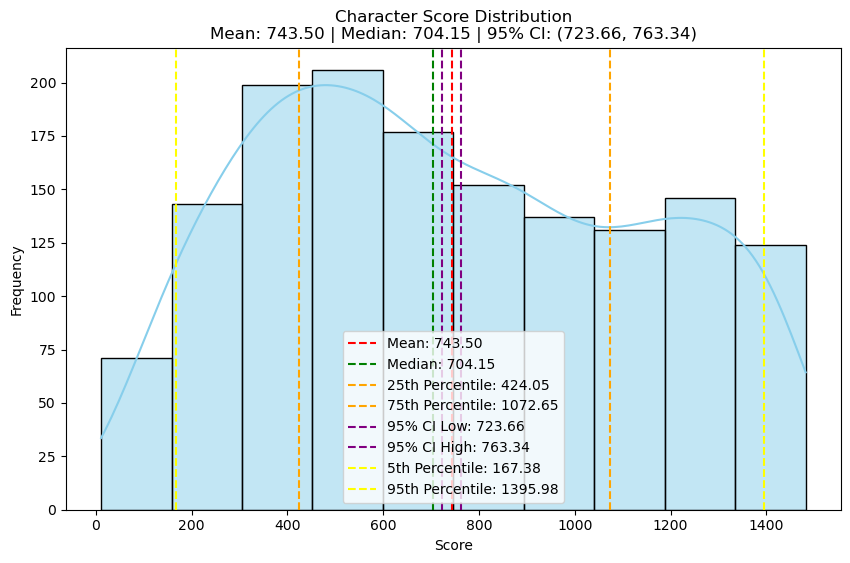

In [91]:
import seaborn as sns

# Extract the scores (values) for plotting
scores = list(result.values())

# Calculate statistics: mean, median, and percentiles (25th and 75th)
mean_score = np.mean(scores)
median_score = np.median(scores)
percentile_25 = np.percentile(scores, 25)
percentile_75 = np.percentile(scores, 75)
percentile_5 = np.percentile(scores, 5)
percentile_95 = np.percentile(scores, 95)

ci_low, ci_high = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=10, color="skyblue", edgecolor="black")

# Add vertical lines for mean, median, percentiles, and confidence interval
plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
plt.axvline(median_score, color='green', linestyle='--', label=f'Median: {median_score:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='--', label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='orange', linestyle='--', label=f'75th Percentile: {percentile_75:.2f}')
plt.axvline(ci_low, color='purple', linestyle='--', label=f'95% CI Low: {ci_low:.2f}')
plt.axvline(ci_high, color='purple', linestyle='--', label=f'95% CI High: {ci_high:.2f}')
plt.axvline(percentile_5, color='yellow', linestyle='--', label=f'5th Percentile: {percentile_5:.2f}')
plt.axvline(percentile_95, color='yellow', linestyle='--', label=f'95th Percentile: {percentile_95:.2f}')

# Add title with statistics
plt.title(f"Character Score Distribution\nMean: {mean_score:.2f} | Median: {median_score:.2f} | "
          f"95% CI: ({ci_low:.2f}, {ci_high:.2f})")

# Add labels and legend
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()


Threshold: 100 - Highest score deleted: Moai with score 98.2
Information about Moai: {'mentions': ['Charlotte Linlin'], 'word_count': 141, 'mentioned_by': [], 'score': 1396.2}

Threshold: 150 - Highest score deleted: Emma with score 145.6
Information about Emma: {'mentions': ['Shanks'], 'word_count': 104, 'mentioned_by': [], 'score': 1364.4}

Threshold: 200 - Highest score deleted: Hip with score 199.5
Information about Hip: {'mentions': ['Charlotte Linlin'], 'word_count': 174, 'mentioned_by': [], 'score': 1301.2}

Threshold: 250 - Highest score deleted: Lines with score 249.9
Information about Lines: {'mentions': ['Fullbody', 'Gin'], 'word_count': 168, 'mentioned_by': ['Gin'], 'score': 1262.8}

Threshold: 300 - Highest score deleted: Catacombo with score 298.4
Information about Catacombo: {'mentions': ['Boa Hancock', 'Kaidou'], 'word_count': 241, 'mentioned_by': [], 'score': 1191.0}

Threshold: 350 - Highest score deleted: Candre with score 350.0
Information about Candre: {'mentions':

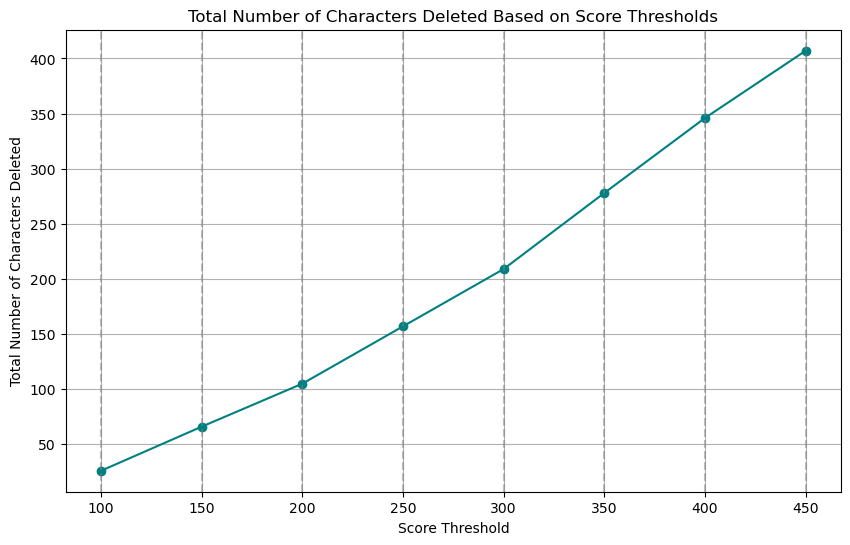

In [105]:
# Extract the scores and their corresponding character names
names = list(result.keys())
scores = list(result.values())

# Define the score thresholds you want to explore (e.g., 100, 150, 200, 250)
score_thresholds = [100, 150, 200, 250, 300, 350, 400, 450]

# Initialize a list to store the number of characters removed and the highest score character info
num_deleted = []
deleted_character_info = []

# Loop over the score thresholds and calculate the number of characters removed
for threshold in score_thresholds:
    # Filter out characters whose scores are less than or equal to the threshold
    filtered_scores = [score for score in scores if score <= threshold]
    filtered_names = [names[i] for i in range(len(scores)) if scores[i] <= threshold]
    
    # Track the highest score character deleted
    if filtered_scores:
        max_deleted_score = max(filtered_scores)
        max_deleted_name = filtered_names[filtered_scores.index(max_deleted_score)]
        deleted_character_info.append((max_deleted_name, max_deleted_score))
    else:
        deleted_character_info.append(("None", 0))  # No character deleted if list is empty
    
    num_deleted.append(len(filtered_scores))  # Store the total number deleted

# Print out the highest score character deleted for each threshold
for i, threshold in enumerate(score_thresholds):
    character, score = deleted_character_info[i]
    print(f"Threshold: {threshold} - Highest score deleted: {character} with score {score}")
    print(f"Information about {character}: {summary[character]}\n")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(score_thresholds, num_deleted, marker='o', linestyle='-', color='teal')

# Add title and labels
plt.title("Total Number of Characters Deleted Based on Score Thresholds")
plt.xlabel("Score Threshold")
plt.ylabel("Total Number of Characters Deleted")

# Add vertical lines for key thresholds
for threshold in score_thresholds:
    plt.axvline(threshold, color='gray', linestyle='--', alpha=0.5)

# Show the plot
plt.grid(True)
plt.show()

I consider amazon as a quite relevant one so lets keep her as the reference value and delete the previous ones

In [113]:
# Get the names of the characters with score > 445
top_characters = [name for name, score in result.items() if score > 445]
print(top_characters[-5:])

# Get the deleted characters
deleted_characters = [name for name, score in result.items() if score <= 445]
print(deleted_characters[-5:])

# Print the before and after length of the character summary
print(f"Before: {len(summary)} characters")

# After removing the top characters
print(f"After: {len(top_characters)} characters")

['Magra', 'Amazon', 'Stealth Black', 'Nefertari Titi', 'Monda']
['Okome', 'Eiri', 'Noriko', 'Yamon', 'Deigoro']
Before: 1486 characters
After: 1083 characters


In [120]:
# Function to remove deleted characters and update the dictionary
def remove_deleted_characters_from_summary(summary_dict, deleted_characters):
    filtered_summary = {}

    for character, data in summary_dict.items():
        # Skip the character if it's deleted
        if character in deleted_characters:
            continue

        # Filter out mentions and mentioned_by lists
        mentions = [name for name in data['mentions'] if name not in deleted_characters]
        mentioned_by = [name for name in data['mentioned_by'] if name not in deleted_characters]

        # Update the dictionary with filtered mentions and mentioned_by
        filtered_summary[character] = {
            'mentions': mentions,
            'word_count': data['word_count'],
            'mentioned_by': mentioned_by,
            'score': data['score']
        }

    return dict(sorted(filtered_summary.items()))

# Apply the function to remove deleted characters
filtered_summary = remove_deleted_characters_from_summary(summary, deleted_characters)

# Print the filtered summary
print("Filtered Summary Dictionary:")
print(len(filtered_summary))
filtered_summary['Abdullah']

Filtered Summary Dictionary:
1083


{'mentions': ['Bartholomew Kuma',
  'Bartolomeo',
  'Bastille',
  'Bellamy',
  'Blue Gilly',
  'Bobby Funk',
  'Cavendish',
  'Chinjao',
  'Dagama',
  'Donquixote Doflamingo',
  'Elizabello II',
  'Hajrudin',
  'Ideo',
  'Issho',
  'Jeet',
  'Kelly Funk',
  'Monkey D. Luffy',
  'Orlumbus',
  'Pica',
  'Riku Doldo III',
  'Roronoa Zoro',
  'Sugar',
  'Suleiman',
  'Tank Lepanto',
  'Trafalgar D. Water Law',
  'Ucy',
  'Usopp'],
 'word_count': 1769,
 'mentioned_by': ['Bartholomew Kuma',
  'Bastille',
  'Bellamy',
  'Blue Gilly',
  'Boo',
  'Chinjao',
  'Dagama',
  'Elizabello II',
  'Hajrudin',
  'Ideo',
  'Jeet',
  'Orlumbus',
  'Pandaman',
  'Pica',
  'Sai',
  'Suleiman',
  'Tank Lepanto',
  'Ucy'],
 'score': 240.4}

In [122]:
# Save summary as json
import json
with open("filtered_summary.json", "w") as f:
    json.dump(filtered_summary, f, indent=4)